# **1. Of cats and cookies**

Tactile Entertainment created the wildly famous smartphone puzzle game Cookie Cats. To clear the board and complete the level, the player must link tiles of the same hue in this traditional "connect three" puzzle game.

Players will occasionally come across gates as they advance through the game's stages that require them to wait a significant length of time or spend an in-app purchase in order to pass. These gates serve the crucial function of forcing players to take breaks from playing the game, which should boost and prolong the player's pleasure of the game in addition to encouraging in-app purchases.

Where should the gates be situated? In Cookie Cats, the first gate was initially situated at level 30, but in this notebook, we'll investigate an AB-test in which we moved it to level 40. We'll focus on the effect on player retention in particular.

In [16]:
#importing pandas
import pandas as pd

In [3]:
#Reading the Data
df=pd.read_csv('/content/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# **2. The AB-test data**

The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:


**userid**  - a unique number that identifies each player.

**version** - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).

**sum_gamerounds** - the number of game rounds played by the player during the first 14 days after install.

**retention_1** - did the player come back and play 1 day after installing?

**retention_7** - did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. As a sanity check, let's see if there are roughly the same number of players in each AB group.

In [4]:
# Counting the number of players in each AB group.
df.groupby('version')['userid'].count()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

# **3. The distribution of game rounds**

The focus of this analysis will be on how the gate placement affects player retention, but just for fun: Let's plot the distribution of the number of game rounds players played during their first week playing the game.

Text(0, 0.5, 'Number of Users')

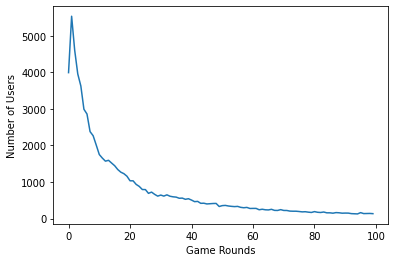

In [17]:
# Counting the number of players for each number of gamerounds
plot_df=df.groupby('sum_gamerounds')['userid'].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax=plot_df.head(100).plot(x='sum_gamerounds',y='userid')
ax.set_xlabel('Game Rounds')
ax.set_ylabel('Number of Users')

# **4. Overall 1-day retention**
We can see from the plot above that some people download the game but never play it (0 game rounds), some players only play a few game rounds in their first week, and some players get completely enamored with the game!

The goal is for players to enjoy the experience and become addicted. The percentage of players that return to play a game one day after installing it is a widely used indicator in the video game industry of how entertaining and captivating a game is. The easier it is to keep players and develop a sizable player base, the greater 1-day retention is.

Let's start by taking a general look of 1-day retention.

In [18]:
# The % of users that came back the day after they installed
df['retention_1'].mean()

0.4452095044850259

# **5. 1-day retention by AB-group**

So, one day after installing the game, a little under half of the gamers return. We may compare the two AB-groups' 1-day retention levels now that we have a benchmark.

In [19]:
# Calculating 1-day retention for each AB-group
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

# **6. Should we be confident in the difference?**

In comparison to the control when the gate was at level 30(44.8%), it appears that there was a minor drop in 1-day retention (44.2 %). It's a minor adjustment, but retention can be significantly impacted by even minor adjustments. How confident should we be that a gate at level 40 will be worse in the future, even though we are convinced of the difference in the data?

We can determine the degree of certainty in these retention rates in a few different methods. We'll use bootstrapping in this case: Our dataset will be repeatedly re-sampled (with replacement), and for those samples, 1-day retention will be determined. We can tell how dubious the retention data are by looking at the variation in 1-day retention.

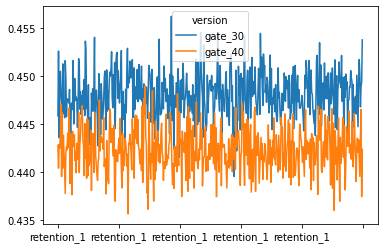

In [43]:
# Creating an list with bootstrapped means for each AB-group
boot_1d=[]
for i in range(500):
  boot_mean=df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
  boot_1d.append(boot_mean)

# Transforming the list to a DataFrame
boot_1d=pd.DataFrame(boot_1d)

# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot()

# **7. Zooming in on the difference**

For the two AB-groups, these two distributions above show the bootstrap uncertainty of the underlying 1-day retention. Simply by skimming this figure, we can tell that they appears to be some, albeit minor, evidence of a difference. Focusing on the variation in 1-day retention.

(Take notice that to keep the calculations moving quickly, we've capped the number of bootstrap replications in this notebook at 500.) This would most certainly be increased to a much higher amount in "production," like 10,000.)

Text(0.5, 0, 'Difference for AB-groups')

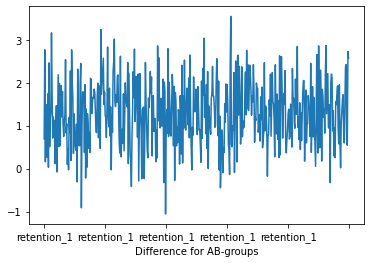

In [56]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff']=((boot_1d['gate_30']-boot_1d['gate_40'])*100/boot_1d['gate_40'])

# Ploting the bootstrap % difference
ax=boot_1d['diff'].plot()
ax.set_xlabel('Difference for AB-groups')

# **8. The probability of a difference**

According to this graph, the most likely percent difference is between 1 and 2 percent, and the majority of the distribution is above 0%, favoring a gate at level 30. But what is the likelihood that the difference is greater than 0%? Let's figure it out as well.

In [57]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob=(boot_1d['diff']>0).mean()

# Pretty printing the probability
prob

0.958

# **9. 7-day retention by AB-group**

According to the bootstrap study, there is a good chance that a level 30, gate will result in greater 1-day retention. The majority of players probably haven't attained level 30 yet, given that players have only been playing the game for one day. That is, even if the gate appears at level 30, many players won't have been impacted by it.

However, more players ought to have attained level 40 after a week of play, therefore it makes reasonable to also consider 7-day retention. That is, what proportion of those who downloaded the game returned a week later to play it again.

First, let's determine the 7-day retention for the two AB-groups.

In [59]:
df['retention_7'].mean()

0.1860648194347426

In [60]:
# Calculating 7-day retention for both AB-groups
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

# **10. Bootstrapping the difference again**

Similar to 1-day retention, we observe that when the gate is at level 40 compared to level 30(19.02%), 7-day retention is marginally lower (18.2%). Additionally, this disparity is greater than for 1-day retention, most likely as a result of more players having had a chance to enter the first gate. More people don't play a game a day after installing it than a week later, as shown by the fact that the overall 7-day retention is lower than the overall 1-day retention.

To determine how certain we should be about the difference between the AB-groups, let's apply bootstrap analysis as before.

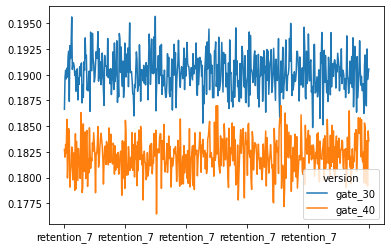

In [69]:
# Creating a list with bootstrapped means for each AB-group
boot_7d=[]

for i in range(500):
  boot_mean=df.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
  boot_7d.append(boot_mean)

# Transforming the list to a DataFrame
boot_7d=pd.DataFrame(boot_7d)
boot_7d.plot()

Text(0.5, 0, '% difference in means')

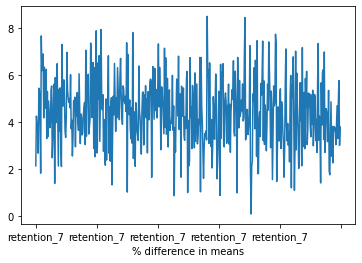

In [70]:
# Adding a column with the % difference between the two AB-groups
boot_7d['diff']=((boot_7d['gate_30']-boot_7d['gate_40'])*100/boot_7d['gate_40'])

# Ploting the bootstrap % difference
ax=boot_7d['diff'].plot()
ax.set_xlabel('% difference in means')

In [71]:
# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob=(boot_7d['diff']>0).mean()

# Pretty printing the probability
prob

1.0

# **11. The conclusion**

According to the bootstrap finding, there is convincing evidence that when the gate is at level 30 as opposed to level 40, 7-day retention is higher. The conclusion is that we shouldn't move the gate from level 30 to level 40 if we want to maintain good retention—both 1-day and 7-day retention. Of course, there are further metrics we might examine, such as the quantity of game rounds played or the amount of in-game purchases made by the two AB-groups. However, one of the most crucial measures is retention. It doesn't matter how much money players spend in-game if we can't keep them as customers.

Why does retention increase when the gate is placed earlier? The reverse might be anticipated: The longer people play the game, the later the hurdle will be. But the evidence do not support this. One explanation for this is the hedonic adaptation idea.Hedonic adaptation, to put it briefly, is the propensity for humans to derive less and less pleasure over time from an enjoyable activity if that action is continued. Players' enjoyment of the game is increased by making them stop when they get to a gate. However, fewer players reach level 40 when the gate is moved there, and those who do are more likely to abandon the game out of boredom.

In [1]:
# So, given the data and the bootstrap analysis
# Should we move the gate from level 30 to level 40 ?
move_to_level_40 = False